### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.1168*1,0],
    [0.1168*2,0], 
    [0.1168*3,0],
    [0.1168*4,0],
    [0.1168*5,0],
    [0.1168*6,0],
    [0.1168*7,0],
    [0.1168*8,0],
    [0.1168*9,0], 
    [0.1168*10,0],
    [0.1168*11,0],
    [0.1168*12,0],

] 

#wgs84

# for each edge (between above coordinates) specify the depth (m)
depths = [18,18,18,18,18,18,18,18,18,18,18,18,]
current_speeds = [0,0,0,0,0,0,0,0,0,0,0,0] 
V_g_profile = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile": V_g_profile[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

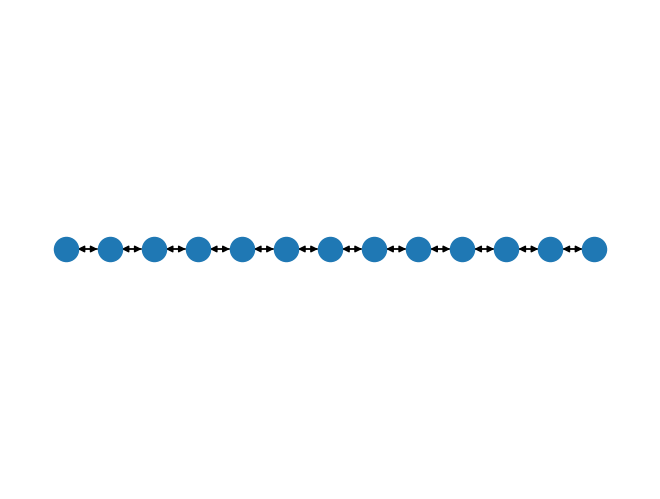

In [4]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground Profile {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile"]))

General depth for edge ('Node 0', 'Node 1') is 18
Current speed for edge ('Node 0', 'Node 1') is 0
Vessel Speed To Ground Profile ('Node 0', 'Node 1') is 0.5
General depth for edge ('Node 1', 'Node 0') is 18
Current speed for edge ('Node 1', 'Node 0') is 0
Vessel Speed To Ground Profile ('Node 1', 'Node 0') is 0.5
General depth for edge ('Node 1', 'Node 2') is 18
Current speed for edge ('Node 1', 'Node 2') is 0
Vessel Speed To Ground Profile ('Node 1', 'Node 2') is 1
General depth for edge ('Node 2', 'Node 1') is 18
Current speed for edge ('Node 2', 'Node 1') is 0
Vessel Speed To Ground Profile ('Node 2', 'Node 1') is 1
General depth for edge ('Node 2', 'Node 3') is 18
Current speed for edge ('Node 2', 'Node 3') is 0
Vessel Speed To Ground Profile ('Node 2', 'Node 3') is 1.5
General depth for edge ('Node 3', 'Node 2') is 18
Current speed for edge ('Node 3', 'Node 2') is 0
Vessel Speed To Ground Profile ('Node 3', 'Node 2') is 1.5
General depth for edge ('Node 3', 'Node 4') is 18
Curren

### Create vessel - add VesselProperties and ConsumesEnergy mixins


In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

#### vessel_01  loaded


In [331]:
# Create a dict with all important settings

#### Barge1000
data_vessel_01 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 1.2,  # m/s
    "type": None,
    "B": 11,
    "L": 62,
    "H_e": None, 
    "H_f": None, 
    "T": 3.85,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 750, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": True,
    "consider_wind_influence":True,
    "U_wind": 7.9, # m/s
    "rel_winddir":0, #degree
    "load": 'loaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}                



#### vessel_02  unloaded, downstream 

In [332]:
# Create a dict with all important settings

data_vessel_02 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 1.2,  # m/s
    "type": None,
    "B": 11,
    "L": 62,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 750, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": True,
    "consider_wind_influence":True,
    "U_wind":5.4, # m/s
    "rel_winddir":180, #degree
    "load": 'unloaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}            



### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [333]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[12].name)
path_downstream = nx.dijkstra_path(FG, nodes[12].name, nodes[0].name)

### Define simulation

In [334]:
def run_simulation_01(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_01)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [335]:
def run_simulation_02(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_02)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### Run simulation


In [336]:
# create empty plot data

vessel_01 = run_simulation_01(V_g_ave = 1.2 , path = path_upstream)

# create an EnergyCalculation object and perform energy consumption calculation
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel_01)
energycalculation.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation.energy_use)
df_upstream.head(15)
#df_upstream['total_energy']



C:\Users\NLFLKO\Anaconda3\envs\sim3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-04-09 15:19:12.000000,2023-04-09 18:19:47.097104,POINT (0 0),POINT (0.1168 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
1,2023-04-09 18:19:47.097104,2023-04-09 21:20:22.194208,POINT (0.1168 0),POINT (0.2336 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
2,2023-04-09 21:20:22.194208,2023-04-10 00:20:57.291312,POINT (0.2336 0),POINT (0.3504 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
3,2023-04-10 00:20:57.291312,2023-04-10 03:21:32.388415,POINT (0.3504 0),POINT (0.4672 0),7.828111,7.828111,750,23.56065,6037.416588,6641.142972,...,267734.660230,0.211876,0.014725,19143.028206,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097103
4,2023-04-10 03:21:32.388415,2023-04-10 06:22:07.485519,POINT (0.4672 0),POINT (0.584 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
5,2023-04-10 06:22:07.485519,2023-04-10 09:22:42.582623,POINT (0.584 0),POINT (0.7008 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
6,2023-04-10 09:22:42.582623,2023-04-10 12:23:17.679727,POINT (0.7008 0),POINT (0.8176 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
7,2023-04-10 12:23:17.679727,2023-04-10 15:23:52.776831,POINT (0.8176 0),POINT (0.9344 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
8,2023-04-10 15:23:52.776831,2023-04-10 18:24:27.873935,POINT (0.9344 0),POINT (1.0512 0),7.828111,7.828111,750,23.56065,6037.416589,6641.142973,...,267734.660254,0.211876,0.014725,19143.028208,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097104
9,2023-04-10 18:24:27.873935,2023-04-10 21:25:02.971038,POINT (1.0512 0),POINT (1.168 0),7.828111,7.828111,750,23.56065,6037.416588,6641.142972,...,267734.660230,0.211876,0.014725,19143.028206,17.246396,405.290303,23.56065,17.991988,13002.116525,10835.097103


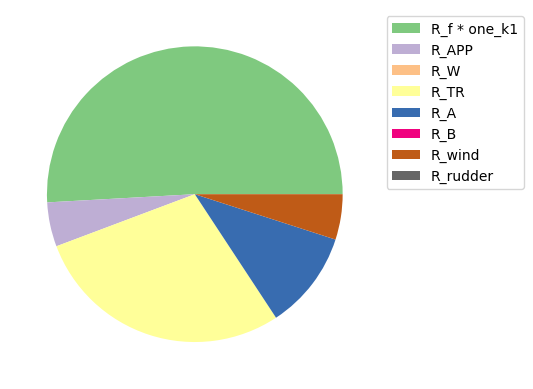

In [337]:
fractions_01 = np.abs(energycalculation.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_01)))
plt.pie(fractions_01, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

In [329]:
vessel_02 = run_simulation_02(V_g_ave = 1.2 , path = path_downstream)

# create an EnergyCalculation object and perform energy consumption calculation
energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel_02)
energycalculation.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation.energy_use)
df_downstream.head(15)



C:\Users\NLFLKO\Anaconda3\envs\sim3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-04-09 15:08:03.000000,2023-04-09 18:08:38.097104,POINT (1.4016 0),POINT (1.2848 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
1,2023-04-09 18:08:38.097104,2023-04-09 21:09:13.194208,POINT (1.2848 0),POINT (1.168 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
2,2023-04-09 21:09:13.194208,2023-04-10 00:09:48.291312,POINT (1.168 0),POINT (1.0512 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
3,2023-04-10 00:09:48.291312,2023-04-10 03:10:23.388415,POINT (1.0512 0),POINT (0.9344 0),4.486879,4.486879,750,13.504379,3460.497121,3806.538078,...,153458.852388,0.121442,0.00844,10972.307946,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097103
4,2023-04-10 03:10:23.388415,2023-04-10 06:10:58.485519,POINT (0.9344 0),POINT (0.8176 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
5,2023-04-10 06:10:58.485519,2023-04-10 09:11:33.582623,POINT (0.8176 0),POINT (0.7008 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
6,2023-04-10 09:11:33.582623,2023-04-10 12:12:08.679727,POINT (0.7008 0),POINT (0.584 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
7,2023-04-10 12:12:08.679727,2023-04-10 15:12:43.776831,POINT (0.584 0),POINT (0.4672 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
8,2023-04-10 15:12:43.776831,2023-04-10 18:13:18.873935,POINT (0.4672 0),POINT (0.3504 0),4.486879,4.486879,750,13.504379,3460.497122,3806.538079,...,153458.852402,0.121442,0.00844,10972.307947,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097104
9,2023-04-10 18:13:18.873935,2023-04-10 21:13:53.971038,POINT (0.3504 0),POINT (0.2336 0),4.486879,4.486879,750,13.504379,3460.497121,3806.538078,...,153458.852388,0.121442,0.00844,10972.307946,9.885205,232.302328,13.504379,17.995287,13002.116525,10835.097103


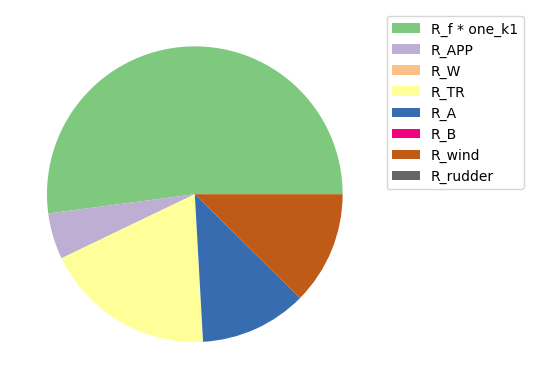

In [330]:
fractions_01 = np.abs(energycalculation.fractions());
plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_01)))
plt.pie(fractions_01, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))
